for misc testing

In [29]:
import xarray as xr
import matplotlib.pyplot as plt

data_home = "/mnt/g/My Drive/GTC"

In [52]:
tom = xr.open_dataset(f"{data_home}/ACCESS_data/MOC.nc")
tom = tom[["MOC"]].drop(["yu_ocean", "st_ocean", "sigma_2"])
aline = xr.open_dataset(f"{data_home}/streamfunctions_ecco/PSI_-60.nc")
aline = aline[["moc"]]
data = xr.merge([tom, aline], join="inner")
data_np = data.to_array().values

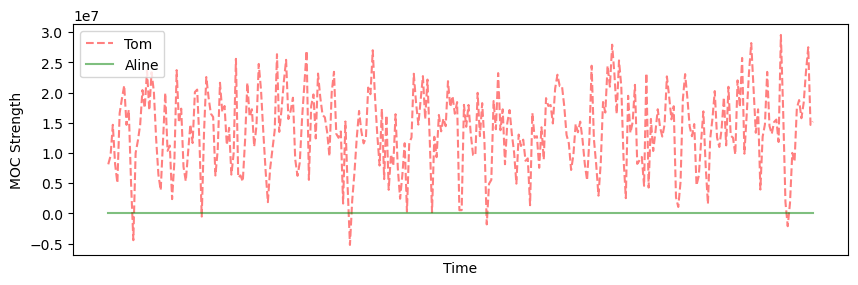

In [53]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(data_np[0, :], color="red", linestyle="--", alpha=0.5, label="Tom")
ax.plot(data_np[1, :], color="green", alpha=0.5, label="Aline")
ax.set_ylabel("MOC Strength"); ax.set_xlabel("Time")
ax.set_xticks([], [])
ax.legend()
plt.show()

In [ ]:
import torch
import torch.nn as nn

class EchoStateNetwork(nn.Module):
    def __init__(self, input_size, reservoir_size, output_size, spectral_radius=0.95):
        super(EchoStateNetwork, self).__init__()
        self.input_size = input_size
        self.reservoir_size = reservoir_size
        self.output_size = output_size

        # Initialize weights
        self.W_in = nn.Parameter(torch.rand(reservoir_size, input_size) - 0.5, requires_grad=False)
        self.W = nn.Parameter(torch.rand(reservoir_size, reservoir_size) - 0.5, requires_grad=False)

        # Scale reservoir weights to ensure ESP
        with torch.no_grad():
            eigvals, _ = torch.eig(self.W, eigenvectors=True)
            radius = eigvals[:,0].abs().max()
            self.W *= spectral_radius / radius

        self.W_out = nn.Parameter(torch.zeros(output_size, reservoir_size + input_size), requires_grad=True)

    def forward(self, X):
        # Collect reservoir states
        states = []
        x = torch.zeros(self.reservoir_size, 1)
        for u in X.unbind(0):
            x = torch.tanh(torch.mm(self.W_in, u.unsqueeze(1)) + torch.mm(self.W, x))
            states.append(torch.cat((x.squeeze(1), u)))

        states = torch.stack(states)
        Y_pred = torch.mm(states, self.W_out.t())
        return Y_pred

    def fit(self, X, Y, reg=1e-8):
        # Forward pass
        Y_pred = self.forward(X)

        # Train output weights using Ridge Regression
        reg_identity = reg * torch.eye(self.reservoir_size + self.input_size)
        self.W_out.data = torch.mm(torch.mm(Y.T, Y_pred), torch.linalg.inv(torch.mm(Y_pred.T, Y_pred) + reg_identity)).t()


In [ ]:
import numpy as np

class EchoStateNetwork(nn.Module):
    # ... [rest of the initialization]

    def __init__(self, input_size, reservoir_size, output_size, spectral_radius=0.95, connectivity=0.1):
        # ... [previous initialization code]

        # Initialize reservoir as an Erdős–Rényi graph
        self.W = nn.Parameter(torch.zeros(reservoir_size, reservoir_size), requires_grad=False)
        for i in range(reservoir_size):
            for j in range(reservoir_size):
                if np.random.rand() < connectivity:
                    self.W[i, j] = torch.tensor(np.random.uniform(-1, 1))

        # Scale for ESP
        with torch.no_grad():
            eigvals, _ = torch.eig(self.W, eigenvectors=True)
            radius = eigvals[:,0].abs().max()
            self.W *= spectral_radius / radius

    # ... [rest of the class]
